In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Example of the linear congruent method

In [2]:
nrandom = 10
x = np.zeros(nrandom, dtype=np.int32)
M = np.int32(256)
c = np.int32(3)
a = np.int32(5)

In [3]:
x[0] = 15
for indx in np.arange(nrandom - 1):
   x[indx + 1] = (x[indx] * a + c) % M
   print(x[indx + 1])

78
137
176
115
66
77
132
151
246


In [8]:
nrandom = 10000
x = np.zeros(nrandom, dtype=np.int32)
x[0] = 15
for indx in np.arange(nrandom - 1):
   x[indx + 1] = (x[indx] * a + c) % M

(array([ 1017.,   975.,  1015.,   977.,  1018.,   978.,  1015.,   975.,
         1015.,  1015.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

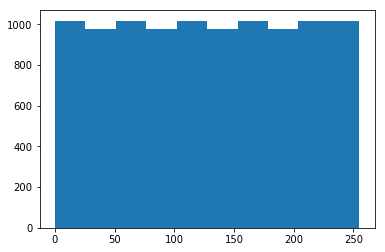

In [11]:
plt.hist(x)

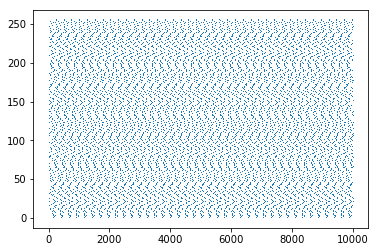

In [9]:
plt.plot(x, ',')

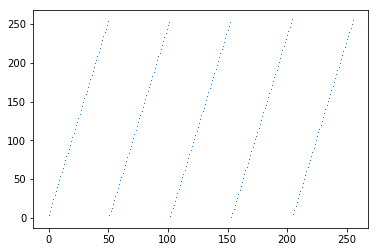

In [10]:
plt.plot(x[0:-2], x[1:-1], ',')